In [1]:
import sys
sys.path.append("../")
from pyproj import CRS
import numpy as np
import sys
from osgeo import gdal
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from datetime import datetime
from time import time
from collections import Counter
import pandas as pd #for data analysing
import openpyxl
import os

In [2]:
##### pour savoir ou je suis dans mon environnement
os.getcwd()

'/home/charlottepoussin/variable'

In [3]:
DEM = xr.open_dataset('DEM_final.nc')

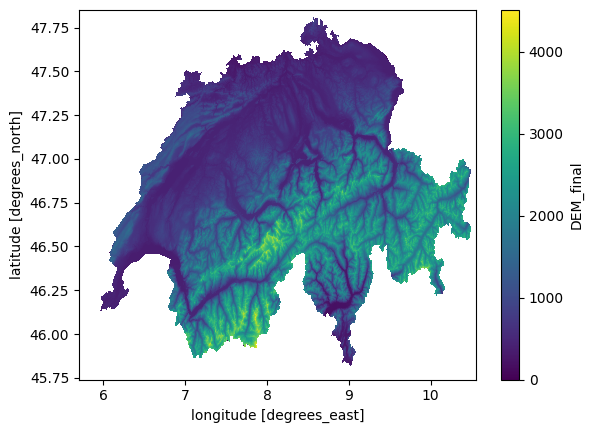

In [5]:
DEM.DEM_final.plot()

In [11]:
DEM

<xarray.Dataset>
Dimensions:    (longitude: 14234, latitude: 6200)
Coordinates:
  * longitude  (longitude) float64 5.7 5.7 5.701 5.701 ... 10.55 10.55 10.55
  * latitude   (latitude) float64 47.85 47.85 47.85 47.85 ... 45.74 45.74 45.74
Data variables:
    crs        int32 ...
    DEM_final  (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.6-23)
    date:         2024-03-22 11:59:11

In [9]:
np.nanmin(DEM.DEM_final.values)

0.0

In [15]:
np.count_nonzero(~np.isnan(DEM.DEM_final))

41982571

In [10]:
DEM.DEM_final.count()

<xarray.DataArray 'DEM_final' ()>
array(41982571)

In [17]:
(DEM.DEM_final.values < 2450).sum()

37196434

In [3]:
###j'ouvre dataset
NDSI_SON = xr.open_dataset('NDSI_DJF_step6_4nb_b_nc.nc')

In [30]:
test = xr.open_dataset('NDSI_DJF_step7_8nb_b_nc.nc')

In [31]:
test

<xarray.Dataset>
Dimensions:     (longitude: 7117, latitude: 6200, z: 105)
Coordinates:
  * longitude   (longitude) float64 8.125 8.126 8.126 ... 10.55 10.55 10.55
  * latitude    (latitude) float64 47.85 47.85 47.85 47.85 ... 45.74 45.74 45.74
  * z           (z) datetime64[ns] 1984-12-01 1985-01-01 ... 2021-12-01
Data variables:
    snow_step5  (z, latitude, longitude) float32 ...

In [4]:
####j'attribue un CRS à mon dataset
crs = CRS.from_string('EPSG:4326')
NDSI_SON.attrs["crs"] = crs.to_proj4()

/home/charlottepoussin/.conda/envs/myenv/lib/python3.12/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [5]:
###j'ouvre le DEM
DEM100_a = xr.open_dataset('DEM100_b.nc')

In [6]:
DEM100_a = DEM100_a.isel(z=0)

In [7]:
DEM100_a.attrs["crs"] = crs.to_proj4()

In [8]:
###on veut metre le DEM dans le dataset
lat = NDSI_SON['latitude'].values
lon = NDSI_SON['longitude'].values
time = NDSI_SON['z'].values

dem = xr.DataArray(DEM100_a.layer.values, coords={'latitude': lat,'longitude':lon}, dims=['latitude','longitude'])

In [9]:
NDSI_SON['DEM'] = dem

In [10]:
####on change en entier le DEM on a pas besoisn de virgule
NDSI_SON['DEM'] = NDSI_SON.DEM.astype('int16')

/home/charlottepoussin/.conda/envs/myenv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:213: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [11]:
##les valeur hors suisse son en 0 et non en NAN por le DEM on va alors les changer en NAN
NDSI_SON['DEM'] = NDSI_SON.DEM.where(NDSI_SON.DEM != 0)

In [29]:
NDSI_SON.z.values

array(['1984-12-01T00:00:00.000000000', '1985-01-01T00:00:00.000000000',
       '1985-02-01T00:00:00.000000000', '1985-12-01T00:00:00.000000000',
       '1986-01-01T00:00:00.000000000', '1986-02-01T00:00:00.000000000',
       '1986-12-01T00:00:00.000000000', '1987-02-01T00:00:00.000000000',
       '1987-12-01T00:00:00.000000000', '1988-01-01T00:00:00.000000000',
       '1988-02-01T00:00:00.000000000', '1988-12-01T00:00:00.000000000',
       '1989-01-01T00:00:00.000000000', '1989-02-01T00:00:00.000000000',
       '1989-12-01T00:00:00.000000000', '1990-01-01T00:00:00.000000000',
       '1990-02-01T00:00:00.000000000', '1990-12-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1991-02-01T00:00:00.000000000',
       '1991-12-01T00:00:00.000000000', '1992-01-01T00:00:00.000000000',
       '1992-02-01T00:00:00.000000000', '1992-12-01T00:00:00.000000000',
       '1993-01-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-12-01T00:00:00.000000000', '1994-01-01

In [13]:
##le faire avant l'analyse et après l'analyse afin de voir le pourcentage de changement
##Before
def compute_cloudpercent_b(array):
    cloud = np.sum(array == 2)
    #print(cloud)
    tot_pix = np.count_nonzero((~np.isnan(array)))
    percentage_cloud_b = round(((float(cloud) / float(tot_pix)) * 100),2)
    return percentage_cloud_b

In [14]:
##le faire avant l'analyse et après l'analyse afin de voir le pourcentage de changement
##Before
def compute_snowpercent_b(array):
    snow = np.count_nonzero((array == 1) | (array == 100))
    #print(snow)
    tot_pix = np.count_nonzero((~np.isnan(array)))
    snow_percent_b = round(((float(snow) / float(tot_pix)) * 100),2)
    return snow_percent_b

In [15]:
##le faire avant l'analyse et après l'analyse afin de voir le pourcentage de changement
##Before
def compute_landpercent_b(array):
    land = np.count_nonzero((array == 0) | (array == 200))
    #print(land)
    tot_pix = np.count_nonzero((~np.isnan(array)))
    land_percent_b = round((float(land) / float(tot_pix)) * 100,2)
    return land_percent_b

In [16]:
##le faire avant l'analyse et après l'analyse afin de voir le pourcentage de changement
##After
def compute_cloudpercent_a(array_copy):
    cloud = np.sum(array_copy  == 2)
    tot_pix = np.count_nonzero((~np.isnan(array_copy)))
    cloud_percent = round((float(cloud) / float(tot_pix)) * 100, 2)
    return cloud_percent

In [17]:
##le faire avant l'analyse et après l'analyse afin de voir le pourcentage de changement
##After
def compute_snowpercent_a(array_copy):
    snow = np.count_nonzero((array_copy == 1) | (array_copy == 100))
    tot_pix = np.count_nonzero((~np.isnan(array_copy)))
    snow_percent = round((float(snow) / float(tot_pix)) * 100, 2)
    return snow_percent

In [18]:
##le faire avant l'analyse et après l'analyse afin de voir le pourcentage de changement
##After
def compute_landpercent_a(array_copy):
    land = np.count_nonzero((array_copy == 0) | (array_copy == 200))
    tot_pix = np.count_nonzero((~np.isnan(array_copy)))
    land_percent = round((float(land) / float(tot_pix)) * 100, 2)
    return land_percent

In [19]:
def step5_gapfilling_cloud(array,array_copy):
    cloud_b = np.sum(array==2)
    cloud_a = np.sum(array_copy==2)
    cloud_step5 = cloud_b - cloud_a 
    step5_gf_cloud = round((float(cloud_step5)/float(cloud_b))*100,2)
    #step3_gf_cloud = ((cloud_step3)/(cloud_b))*100
    return step5_gf_cloud

In [20]:
def step5_gapfilling_tot(array,array_copy):
    cloudpercent_b = compute_cloudpercent_b(array)
    cloudpercent_a = compute_cloudpercent_a(array_copy)
    step5_gf_tot = round(((cloudpercent_b)-(cloudpercent_a)),2)
    #step3_gf_tot = ((cloudpercent_b)-(cloudpercent_a))
    return step5_gf_tot

In [21]:
def step5_internal(array, array_dem):

    # Je crée une copie pour pouvoir travailler dessus sans changer l'initial
    snow_step5 = array.copy(deep=True)

    while True:
        # Get 8 neighboring pixels for raster and dem
        W = snow_step5.values[1:-1, :-2]
        NW = snow_step5.values[:-2, :-2]
        N = snow_step5.values[:-2, 1:-1]
        NE = snow_step5.values[:-2, 2:]
        E = snow_step5.values[1:-1, 2:]
        SE = snow_step5.values[2:, 2:]
        S = snow_step5.values[2:, 1:-1]
        SW = snow_step5.values[2:, :-2]

        Wdem = array_dem.values[1:-1, :-2]
        NWdem = array_dem.values[:-2, :-2]
        Ndem = array_dem.values[:-2, 1:-1]
        NEdem = array_dem.values[:-2, 2:]
        Edem = array_dem.values[1:-1, 2:]
        SEdem = array_dem.values[2:, 2:]
        Sdem = array_dem.values[2:, 1:-1]
        SWdem = array_dem.values[2:, :-2]

        arrdem = array_dem.values[1:-1, 1:-1]
    
        mask_snow = (
        ((((W == 1)| (W == 100)) & (
            arrdem > Wdem)) | (
                ((N == 1)| (N == 100)) & (
                     arrdem > Ndem)) | (
                        ((E == 1)| (E == 100)) & (
                        arrdem > Edem)) | (
                            ((S == 1)| (S == 100)) & (
                                arrdem > Sdem)) | (
                                    ((NW == 1)| (NW == 100)) & (
                                        arrdem > NWdem)) | (
                                            ((NE == 1)| (NE == 100)) & (
                                                arrdem > NEdem)) | (
                                                    ((SE == 1)| (SE == 100)) & (
                                                        arrdem > SEdem)) | (
                                                            ((SW == 1)| (SW == 100)) & (
                                                                arrdem > SWdem))) & (
                                                                    snow_step5.values[
                                                                        1:-1, 1:-1] == 2))

        # Use the mask to set corresponding elements
        snow_step5.values[1:-1, 1:-1][mask_snow] = 100

            # Check if any modification was made in the current iteration
        if not mask_snow.any():
            break  # Exit the loop if no modifications were made

    return snow_step5

In [22]:
def step5(array, array_dem):
    # four-pixels neighboring
    print("Starting step 5")
    ##Calculer le % de nuage avant le processus
    percentage_cloud_b = compute_cloudpercent_b(array)
    print("cloud percent before step 5 : " + str(round(percentage_cloud_b,2)))
    percentage_snow_b = compute_snowpercent_b(array)
    percentage_land_b = compute_landpercent_b(array)
    
    
    # compute 4 pixel snow neighboring
    snow_step5 = step5_internal(array,array_dem)

    percentage_cloud_a = compute_cloudpercent_a(snow_step5)
    print("cloud percent after step 5 : " + str(round(percentage_cloud_a,2)))
    percentage_snow_a = compute_snowpercent_a(snow_step5)
    percentage_land_a = compute_landpercent_a(snow_step5)

    step5_gf_tot = step5_gapfilling_tot(array,snow_step5)
    print("diminution of cloud tot (%) : " + str(round(step5_gf_tot,2)))
    step5_gf_cloud = step5_gapfilling_cloud(array,snow_step5)
    print("diminution of cloud (%) : " + str(round(step5_gf_cloud,2)))
    

    print("End of step 5")

    return snow_step5


In [23]:
cloud_percent_b_list = []
snow_percent_b_list = []
land_percent_b_list = []
cloud_percent_a_list = []
snow_percent_a_list = []
land_percent_a_list = []
step5_gapfilling_tot_list = []
step5_gapfilling_cloud_list = []
time_list = []
snow_step5_list = []

In [24]:
for i in range(len(NDSI_SON.z)):
    print(i)
    snow_step5 = step5(NDSI_SON.snow_step4.isel(z=i),NDSI_SON.DEM)
    snow_step5_list.append(snow_step5)
    cloud_percent_b = compute_cloudpercent_b(NDSI_SON.snow_step4.isel(z=i))
    cloud_percent_b_list.append(cloud_percent_b)
    snow_percent_b = compute_snowpercent_b(NDSI_SON.snow_step4.isel(z=i))
    snow_percent_b_list.append(snow_percent_b)
    land_percent_b = compute_landpercent_b(NDSI_SON.snow_step4.isel(z=i))
    land_percent_b_list.append(land_percent_b)
    time = pd.to_datetime(NDSI_SON.z.isel(z=i).values)
    formatted_date = time.strftime('%Y-%m-%d')
    time_list.append(formatted_date)

    cloud_percent_a = compute_cloudpercent_a(snow_step5)
    cloud_percent_a_list.append(cloud_percent_a)
    snow_percent_a = compute_snowpercent_a(snow_step5)
    snow_percent_a_list.append(snow_percent_a)
    land_percent_a = compute_landpercent_a(snow_step5)
    land_percent_a_list.append(land_percent_a)

    step5_gapfilling_total = step5_gapfilling_tot(NDSI_SON.snow_step4.isel(z=i),snow_step5)
    step5_gapfilling_tot_list.append(step5_gapfilling_total)
    step5_gapfilling_clouds = step5_gapfilling_cloud(NDSI_SON.snow_step4.isel(z=i),snow_step5)
    step5_gapfilling_cloud_list.append(step5_gapfilling_clouds)


0
Starting step 5
cloud percent before step 5 : 44.7
cloud percent after step 5 : 44.12
diminution of cloud tot (%) : 0.58
diminution of cloud (%) : 1.29
End of step 5
1
Starting step 5
cloud percent before step 5 : 24.53
cloud percent after step 5 : 24.43
diminution of cloud tot (%) : 0.1
diminution of cloud (%) : 0.41
End of step 5
2
Starting step 5
cloud percent before step 5 : 49.18
cloud percent after step 5 : 48.75
diminution of cloud tot (%) : 0.43
diminution of cloud (%) : 0.87
End of step 5
3
Starting step 5
cloud percent before step 5 : 63.26
cloud percent after step 5 : 62.69
diminution of cloud tot (%) : 0.57
diminution of cloud (%) : 0.91
End of step 5
4
Starting step 5
cloud percent before step 5 : 3.26
cloud percent after step 5 : 3.14
diminution of cloud tot (%) : 0.12
diminution of cloud (%) : 3.5
End of step 5
5
Starting step 5
cloud percent before step 5 : 70.73
cloud percent after step 5 : 70.12
diminution of cloud tot (%) : 0.61
diminution of cloud (%) : 0.86
End o

In [25]:
snow_step5_concat = xr.concat(snow_step5_list, dim='z')
dataset_step5 = xr.Dataset({'snow_step5': snow_step5_concat})

In [26]:
len(cloud_percent_b_list)

108

In [26]:
data = {
    'Time': time_list,
    'Cloud Percent Before': cloud_percent_b_list,
    'Snow Percent Before': snow_percent_b_list,
    'Land Percent Before': land_percent_b_list,
    'Cloud Percent After': cloud_percent_a_list,
    'Snow Percent After': snow_percent_a_list,
    'Land Percent After': land_percent_a_list,
    'Cloud Reduction (%)': step5_gapfilling_tot_list,
    'Cloud Reduction After (%)': step5_gapfilling_cloud_list,
}

# Créer un DataFrame à partir du dictionnaire
df_step5 = pd.DataFrame(data)
filename = f'df_step7_8nb_DJF_b.xlsx'
filepath = os.path.join('/home/charlottepoussin/Excels', filename)
df_step5.to_excel(filepath, index=False)

In [27]:
df_step5

,Time,Cloud Percent Before,Snow Percent Before,Land Percent Before,Cloud Percent After,Snow Percent After,Land Percent After,Cloud Reduction (%),Cloud Reduction After (%)
0,1984-12-01,44.70,43.69,11.62,44.12,44.26,11.62,0.58,1.29
1,1985-01-01,24.53,64.34,11.13,24.43,64.44,11.13,0.10,0.41
2,1985-02-01,49.18,49.77,1.05,48.75,50.20,1.05,0.43,0.87
3,1985-12-01,63.26,32.31,4.43,62.69,32.88,4.43,0.57,0.91
4,1986-01-01,3.26,82.01,14.73,3.14,82.12,14.73,0.12,3.50
...,...,...,...,...,...,...,...,...,...
100,2020-02-01,6.12,58.60,35.28,5.91,58.81,35.28,0.21,3.46
101,2020-12-01,22.89,61.99,15.13,22.59,62.28,15.13,0.30,1.30
102,2021-01-01,21.24,70.66,8.10,21.00,70.90,8.10,0.24,1.14
103,2021-02-01,1.87,69.03,29.10,1.79,69.10,29.10,0.08,3.93


In [28]:
dataset_step5.to_netcdf('NDSI_DJF_step7_8nb_b_nc.nc')

## Sauver en tif

In [33]:
import rasterio
from rasterio.transform import from_origin

In [34]:
c

<xarray.Dataset>
Dimensions:     (longitude: 14234, latitude: 6200, z: 10)
Coordinates:
  * longitude   (longitude) float64 5.7 5.7 5.701 5.701 ... 10.55 10.55 10.55
  * latitude    (latitude) float64 47.85 47.85 47.85 47.85 ... 45.74 45.74 45.74
  * z           (z) object '2008-12-01' '2009-01-01' ... '2011-12-01'
Data variables:
    snow_step5  (z, latitude, longitude) float32 nan nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

In [46]:
lon_res = (c.longitude[-1] - c.longitude[0]) / len(c.longitude)
lat_res = (c.latitude[-1] - c.latitude[0]) / len(c.latitude)

In [52]:
# Obtenir les coordonnées géographiques et les dimensions
lon = c.longitude.values
lat = c.latitude.values
z = c.z.values
data = c.snow_step5.values

# Spécifier les informations géospatiales
# Assurez-vous de remplacer les valeurs ci-dessous par vos propres informations géospatiales
lon_min = lon.min()
lat_max = lat.max()
lon_res = lon[1] - lon[0]
lat_res = lat[0] - lat[1]

transform = from_origin(lon_min, lat_max, lon_res, lat_res)  # transform (origin_x, origin_y, pixel_width, pixel_height)
crs = "EPSG:4326"  # Système de coordonnées de référence

# Écrire les données dans un fichier GeoTIFF
with rasterio.open(
    "output.tif",
    "w",
    driver="GTiff",
    height=data.shape[1],
    width=data.shape[2],
    count=data.shape[0],
    dtype=str(data.dtype),
    crs=crs,
    transform=transform,
) as dst:
    for i in range(data.shape[0]):
        dst.write(data[i, :, :], i + 1)

In [57]:
DEM100 = xr.concat([DEM100_a, DEM100_b], dim='longitude')

In [63]:
DEM100.layer

<xarray.DataArray 'layer' (z: 1, latitude: 6200, longitude: 14234)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 5.7 5.7 5.701 5.701 ... 10.55 10.55 10.55
  * latitude   (latitude) float64 47.85 47.85 47.85 47.85 ... 45.74 45.74 45.74
  * z          (z) int32 1
Attributes:
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +no_defs
    min:           0.0
    max:           4500.0

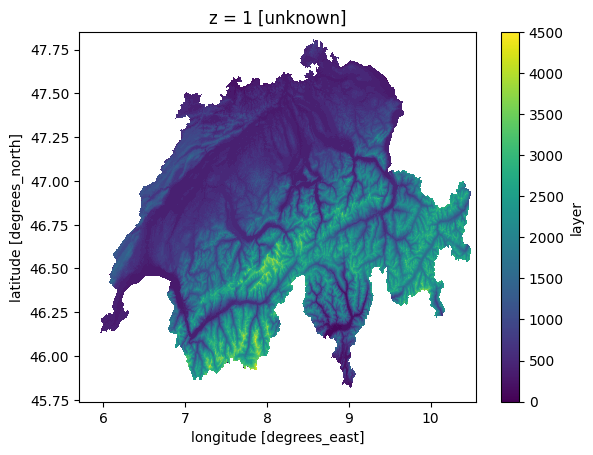

In [64]:
DEM100.layer.isel(z=0).plot()

In [29]:
c.attrs['crs'] = 'EPSG:4326'  # Ajoutez l'attribut CRS au dataset

In [31]:
c.to_netcdf('Echantillon_snow2.nc')

In [65]:
DEM100.to_netcdf("DEM100.nc")

In [53]:
c.z.values

array(['2008-12-01', '2009-01-01', '2009-02-01', '2009-12-01',
       '2010-01-01', '2010-02-01', '2010-12-01', '2011-01-01',
       '2011-02-01', '2011-12-01'], dtype=object)